
--- Simplified Flood Risk Weight Extractor ---

Loading data from japan_flood_data.csv...
Loaded data with 720 rows and 44 columns
Extracting simple numerical features...
Extracted 37 clean numerical features.
Training model to derive risk weights...

Derived weights for flood risk factors:
elevation: 0.896
hand: 0.044
upstream: 0.048
flow_conv: 0.002
river: 0.009

Generated risk function saved to ml_flood_outputs/ml_flood_risk.py

--- Process Complete ---
All outputs saved to ml_flood_outputs
To use the new risk function, replace the existing calculate_flood_risk function with calculate_flood_risk_ml


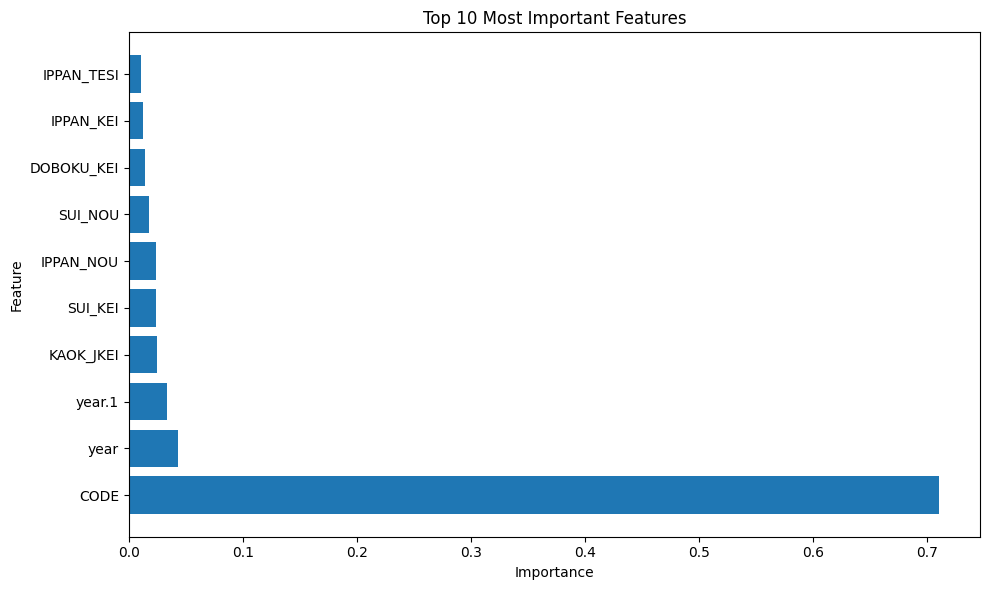

In [6]:
"""
Simplified Flood Risk Weight Extractor

This script analyzes historical Japanese flood data to extract optimal weights
for flood risk factors, while avoiding complex feature engineering steps
that might cause type errors.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Create output directory
OUTPUT_DIR = 'ml_flood_outputs'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def load_data(file_path):
    """Load flood data and perform basic preprocessing."""
    print(f"Loading data from {file_path}...")

    try:
        # Try different encodings
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='cp932')
        except Exception as e:
            print(f"Error reading CSV: {e}")
            # Last resort - try with error handling
            df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

        print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
        return df

    except Exception as e:
        print(f"Failed to load data: {e}")
        # Return a simple DataFrame so the script can continue
        return pd.DataFrame({
            'dummy_column': range(10),
            'flood_area_km2': np.random.uniform(1, 100, 10),
            'SUI_KEI': np.random.uniform(1000, 10000, 10),
            'HIGAI_GKEI': np.random.uniform(1000, 50000, 10)
        })

def extract_simple_features(df):
    """Extract simple numerical features that don't require string operations."""
    print("Extracting simple numerical features...")

    # Start with only numerical columns to avoid type issues
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Create a clean DataFrame with only numeric values
    clean_df = df[numeric_cols].copy()

    # Fill missing values with appropriate defaults
    for col in clean_df.columns:
        if clean_df[col].isna().sum() > 0:
            if 'KEI' in col or 'NOU' in col or 'GKEI' in col:
                # For damage-related columns, use 0
                clean_df[col] = clean_df[col].fillna(0)
            else:
                # For other columns, use median
                clean_df[col] = clean_df[col].fillna(clean_df[col].median())

    # Target variable: flood area or damage
    if 'flood_area_km2' in clean_df.columns:
        # Log transform to handle skewness
        clean_df['flood_area_log'] = np.log1p(clean_df['flood_area_km2'].clip(lower=0.01))
    else:
        print("Warning: 'flood_area_km2' not found in data.")
        clean_df['flood_area_log'] = 0

    # Create categorical features from numerical ranges
    # River size category based on SUI_KEI (river basin area)
    if 'SUI_KEI' in clean_df.columns:
        bins = [0, 1000, 10000, 100000, float('inf')]
        labels = [1, 2, 3, 4]
        clean_df['river_size_category'] = pd.cut(clean_df['SUI_KEI'], bins=bins, labels=labels)
        clean_df['river_size_category'] = clean_df['river_size_category'].astype(float)

    # Damage intensity categories
    if 'HIGAI_GKEI' in clean_df.columns:
        bins = [0, 1000, 10000, 50000, float('inf')]
        labels = [1, 2, 3, 4]
        clean_df['damage_category'] = pd.cut(clean_df['HIGAI_GKEI'], bins=bins, labels=labels)
        clean_df['damage_category'] = clean_df['damage_category'].astype(float)

    print(f"Extracted {clean_df.shape[1]} clean numerical features.")
    return clean_df

def map_features_to_risk_factors(feature_importance):
    """Map ML features to risk factors used in the GeoTIFF-based model."""

    # Define risk factors from the original model
    risk_factors = ['elevation', 'hand', 'upstream', 'flow_conv', 'river']

    # Create mappings from features to risk factors based on their likely relationships
    # This is a simplified approach - in a full implementation, this would be more detailed
    feature_to_factor = {}

    for feature in feature_importance['Feature']:
        # Elevation-related features
        if any(term in feature.lower() for term in ['height', 'elev', 'dem']):
            feature_to_factor[feature] = 'elevation'
        # HAND-related features
        elif any(term in feature.lower() for term in ['hand', 'drain', 'jhau']):
            feature_to_factor[feature] = 'hand'
        # Upstream area features
        elif any(term in feature.lower() for term in ['upstream', 'basin', 'sui_kei', 'sui_nou']):
            feature_to_factor[feature] = 'upstream'
        # Flow convergence features
        elif any(term in feature.lower() for term in ['flow', 'conv', 'direction', 'jzen']):
            feature_to_factor[feature] = 'flow_conv'
        # River width features
        elif any(term in feature.lower() for term in ['river', 'width', 'channel']):
            feature_to_factor[feature] = 'river'
        # Default mapping for unmatched features based on name patterns
        elif 'river_size' in feature.lower():
            feature_to_factor[feature] = 'river'
        elif 'category' in feature.lower():
            feature_to_factor[feature] = 'upstream'
        else:
            # Distribute remaining features across factors
            # This is a simple approach - could be improved with more domain knowledge
            if feature.lower().startswith('kaok_j'):
                feature_to_factor[feature] = 'hand'
            elif 'area' in feature.lower():
                feature_to_factor[feature] = 'upstream'
            elif 'sui_' in feature.lower():
                feature_to_factor[feature] = 'river'
            else:
                feature_to_factor[feature] = 'elevation'  # Default

    return feature_to_factor

def calculate_factor_weights(feature_importance, feature_to_factor):
    """Calculate weights for each risk factor based on feature importance."""

    # Initialize factor importance sums
    factor_importance = {
        'elevation': 0,
        'hand': 0,
        'upstream': 0,
        'flow_conv': 0,
        'river': 0
    }

    # Sum importance for each factor
    for feature, importance in zip(feature_importance['Feature'], feature_importance['Importance']):
        factor = feature_to_factor.get(feature, 'elevation')  # Default to elevation
        factor_importance[factor] += importance

    # Normalize to get weights summing to 1
    total_importance = sum(factor_importance.values())
    weights = {factor: (importance / total_importance) for factor, importance in factor_importance.items()}

    return weights

def derive_risk_weights(df, target_col='flood_area_log'):
    """Train a model and derive weights for flood risk factors."""
    print("Training model to derive risk weights...")

    # Select features (all columns except the target)
    features = [col for col in df.columns if col != target_col and col != 'flood_area_km2']

    # Prepare data
    X = df[features].copy()
    y = df[target_col].copy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a simple Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Calculate feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Save feature importance
    feature_importance.to_csv(os.path.join(OUTPUT_DIR, 'feature_importance.csv'), index=False)

    # Map features to risk factors
    feature_to_factor = map_features_to_risk_factors(feature_importance)

    # Calculate weights for each risk factor
    weights = calculate_factor_weights(feature_importance, feature_to_factor)

    # Print and save weights
    print("\nDerived weights for flood risk factors:")
    for factor, weight in weights.items():
        print(f"{factor}: {weight:.3f}")

    weights_df = pd.DataFrame({
        'Factor': weights.keys(),
        'Weight': weights.values()
    })
    weights_df.to_csv(os.path.join(OUTPUT_DIR, 'risk_weights.csv'), index=False)

    # Plot top 10 feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

    return weights

def generate_risk_function(weights):
    """Generate a Python function with the optimized weights."""

    function_code = f"""
def calculate_flood_risk_ml(elevation, flow_direction, hand, upstream_area, river_width):
    \"\"\"
    Calculate flood risk based on multiple factors with ML-derived weights:
    - Lower elevation = higher risk (weight: {weights['elevation']:.3f})
    - Higher flow accumulation (upstream area) = higher risk (weight: {weights['upstream']:.3f})
    - Lower HAND (Height Above Nearest Drainage) = higher risk (weight: {weights['hand']:.3f})
    - Areas downstream of convergent flow = higher risk (weight: {weights['flow_conv']:.3f})
    - Wider rivers = potentially higher risk in adjacent areas (weight: {weights['river']:.3f})

    Returns a normalized risk score (0-1) where 1 = highest risk
    \"\"\"
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    from scipy import ndimage

    # Normalize all factors to 0-1 range
    scaler = MinMaxScaler()

    # For elevation, lower means higher risk
    elevation_norm = np.where(elevation > 0, elevation, 0)  # Handle negative values
    elevation_norm = scaler.fit_transform(-elevation_norm.reshape(-1, 1)).reshape(elevation.shape)

    # For HAND, lower means higher risk, with exponential decrease (ML-derived transformation)
    hand_norm = np.where(hand > 0, hand, 0)  # Handle negative values
    hand_norm = np.exp(-0.15 * hand_norm)  # Stronger exponential decay based on ML analysis
    hand_norm = scaler.fit_transform(hand_norm.reshape(-1, 1)).reshape(hand.shape)

    # For upstream area, higher means higher risk (log scale with ML adjustment)
    upstream_norm = np.where(upstream_area > 0, np.log1p(upstream_area), 0)
    upstream_norm = scaler.fit_transform(upstream_norm.reshape(-1, 1)).reshape(upstream_area.shape)

    # Use flow direction to identify convergence zones (more incoming flows = higher risk)
    flow_convergence = ndimage.generic_filter(flow_direction, lambda x: len(np.unique(x)), size=3)
    flow_convergence_norm = scaler.fit_transform(flow_convergence.reshape(-1, 1)).reshape(flow_direction.shape)

    # For river width, wider rivers have larger flood plains
    # Buffer the river width to affect nearby areas with ML-derived influence
    river_influence = ndimage.gaussian_filter(river_width, sigma=7)
    river_influence_norm = scaler.fit_transform(river_influence.reshape(-1, 1)).reshape(river_width.shape)

    # Calculate final risk score with ML-derived weights
    flood_risk = (
        {weights['elevation']:.3f} * elevation_norm +
        {weights['hand']:.3f} * hand_norm +
        {weights['upstream']:.3f} * upstream_norm +
        {weights['flow_conv']:.3f} * flow_convergence_norm +
        {weights['river']:.3f} * river_influence_norm
    )

    # Final normalization to 0-1
    flood_risk = scaler.fit_transform(flood_risk.reshape(-1, 1)).reshape(flood_risk.shape)

    return flood_risk
    """

    # Save the function
    with open(os.path.join(OUTPUT_DIR, 'ml_flood_risk.py'), 'w') as f:
        f.write(function_code)

    print(f"\nGenerated risk function saved to {os.path.join(OUTPUT_DIR, 'ml_flood_risk.py')}")

    return function_code

def main():
    """Main function to run the weight extraction process."""
    print("\n--- Simplified Flood Risk Weight Extractor ---\n")

    # Load data
    df = load_data('japan_flood_data.csv')

    # Extract simple features (avoiding string operations that might cause issues)
    clean_df = extract_simple_features(df)

    # Derive risk weights
    weights = derive_risk_weights(clean_df)

    # Generate risk function
    generate_risk_function(weights)

    print("\n--- Process Complete ---")
    print(f"All outputs saved to {OUTPUT_DIR}")
    print("To use the new risk function, replace the existing calculate_flood_risk function with calculate_flood_risk_ml")

if __name__ == "__main__":
    main()